In [2]:
# imports

import pandas as pd
import re
import duckdb
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors


In [3]:
# define directories

analytics_dir = os.getcwd()
os.chdir("..")
root_dir = os.getcwd()

In [ ]:
def clean_metro_data(line):
    # Match the first two tab-separated elements: station name and ID (e.g., A12)
    match = re.match(r'^([^\t]+)\t([A-Z]\d{2})', line)
    if match:
        return f"{match.group(1)}\t{match.group(2)}"
    return None

# Example
lines = [
    "Franconia–Springfield	J03	June 29, 1997			Virginia Railway Express",
"Southern terminus",
"Van Dorn Street	J02	June 15, 1991			",
"King Street–Old Town	C13	December 17, 1983			Amtrak Virginia Railway Express at Alexandria Union Station",
"Transfer station for the Yellow Line (southern)",
"Braddock Road	C12		",
"Potomac Yard	C11	May 19, 2023			Infill station",
"National Airport	C10	July 1, 1977			",
"Crystal City	C09			Virginia Railway Express Manassas Line, Fredericksburg Line",
"Pentagon City	C08			",
"Pentagon	C07			Built as a multi-level station due to geographic constraints, with trains heading south towards Huntington (Yellow Line) and Franconia–Springfield (Blue Line) on the lower level, and trains heading north towards Mount Vernon Square (Yellow Line) and Largo (Blue Line) on the upper level.",
"Arlington Cemetery	C06			",
"Rosslyn	C05		 	Another multi-level station. Transfer station for the Orange and Silver Lines to join on same track",
"Foggy Bottom–GWU	C04		",
"Farragut West	C03		Out of station interchange (OSI) to the Red Line's Farragut North station, which is located just one block away. There have been proposals to connect up the two stations through an underground passageway, though it has not been financed.",
"McPherson Square	C02		",
"Metro Center	C01		  	Transfer station for the Red Line",
"Federal Triangle	D01		 	",
"Smithsonian	D02		",
"L'Enfant Plaza	D03		   	Virginia Railway Express at L'Enfant",
"Transfer station for the Green and Yellow Lines",
"Federal Center SW	D04		 	",
"Capitol South	D05		",
"Eastern Market	D06		",
"Potomac Avenue	D07		",
"Stadium–Armory	D08		Transfer station for the Orange Line",
"Benning Road	G01	November 22, 1980			",
"Capitol Heights	G02		",
"Addison Road	G03		",
"Morgan Boulevard	G04	December 18, 2004		",
"Largo	G05"
]
pre_cleaned = [clean_metro_data(line) for line in lines]

def clean_station_lines(lines):
    cleaned = []
    for line in lines:
        if line:
            # Match station name + ID, ignoring tabs and multiple spaces
            match = re.match(r'^(.*?)\s+([A-Z]\d{2})\b', line.strip())
            if match:
                station, code = match.groups()
                cleaned.append(f"{station},{code},blue")
    return cleaned

# Process
lines = []
for line in pre_cleaned:
    if line:
        lines.append(line.strip().splitlines())
cleaned_lines = clean_station_lines(pre_cleaned)

# # Output
# for line in cleaned_lines:
#     print(line)

import csv

with open("source_files/cleaned_stations.csv", "a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Station Name", "Station ID", "Metroline"])
    for line in cleaned_lines:
        writer.writerow(line.split(","))

In [23]:
# os.chdir("..")
with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql("from stg_ridership;").df()

In [24]:
raw.head()

,ridership_key,ent_station,ext_station,ent_time_period,day_type,riders,trip_length
0,ba08dc9fc4c2477de67bd000e38f6c9e,addison road,addison road,AM Peak,weekday,7.772727,0
1,28074a97ee94dba0bcd953f03a70bef2,addison road,anacostia,AM Peak,weekday,10.363636,11
2,4ee1ff0188c3548f94b23b52837f84e9,addison road,archives,AM Peak,weekday,35.181818,9
3,472fd9c4b9ec742cc4cedb76ed680e40,addison road,arlington cemetery,AM Peak,weekday,0.409091,10
4,94c8218592bf00604b72dcb315ae0776,addison road,ballston-mu,AM Peak,weekday,22.727273,15


In [8]:
entry_df = raw.groupby(['ext_station', 'day_type']).agg({'riders':'sum'}).reset_index(drop=False)

In [13]:
entry_df[entry_df['ext_station'].str.contains('federal triangle')].head()

,ext_station,day_type,riders
87,federal triangle,saturday,2954.750000
88,federal triangle,sunday,2805.250000
89,federal triangle,weekday,9706.284091


In [32]:
with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql("from mart__exit_volume_by_station_and_period;").df()

/Users/jjgutzmann/coding/projects/dc_public_transport/dctrans/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


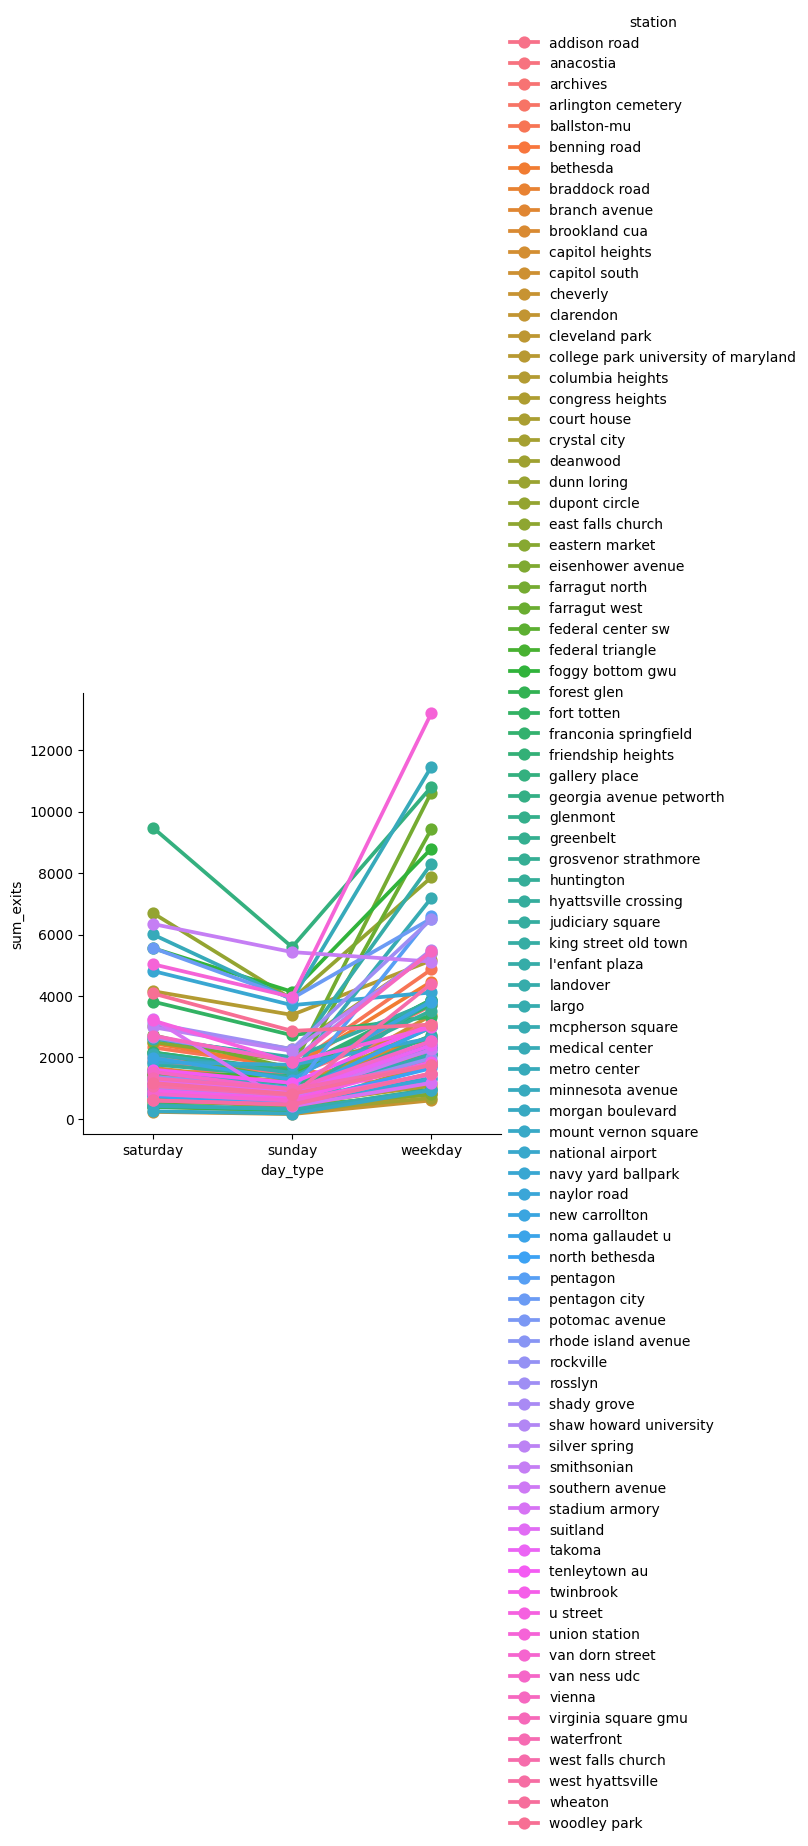

In [34]:
sns.catplot(
    x="day_type",
    y="sum_exits",
    data=raw,
    hue="station",
    kind="point",
    errorbar=None
)
plt.show()

/Users/jjgutzmann/coding/projects/dc_public_transport/dctrans/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


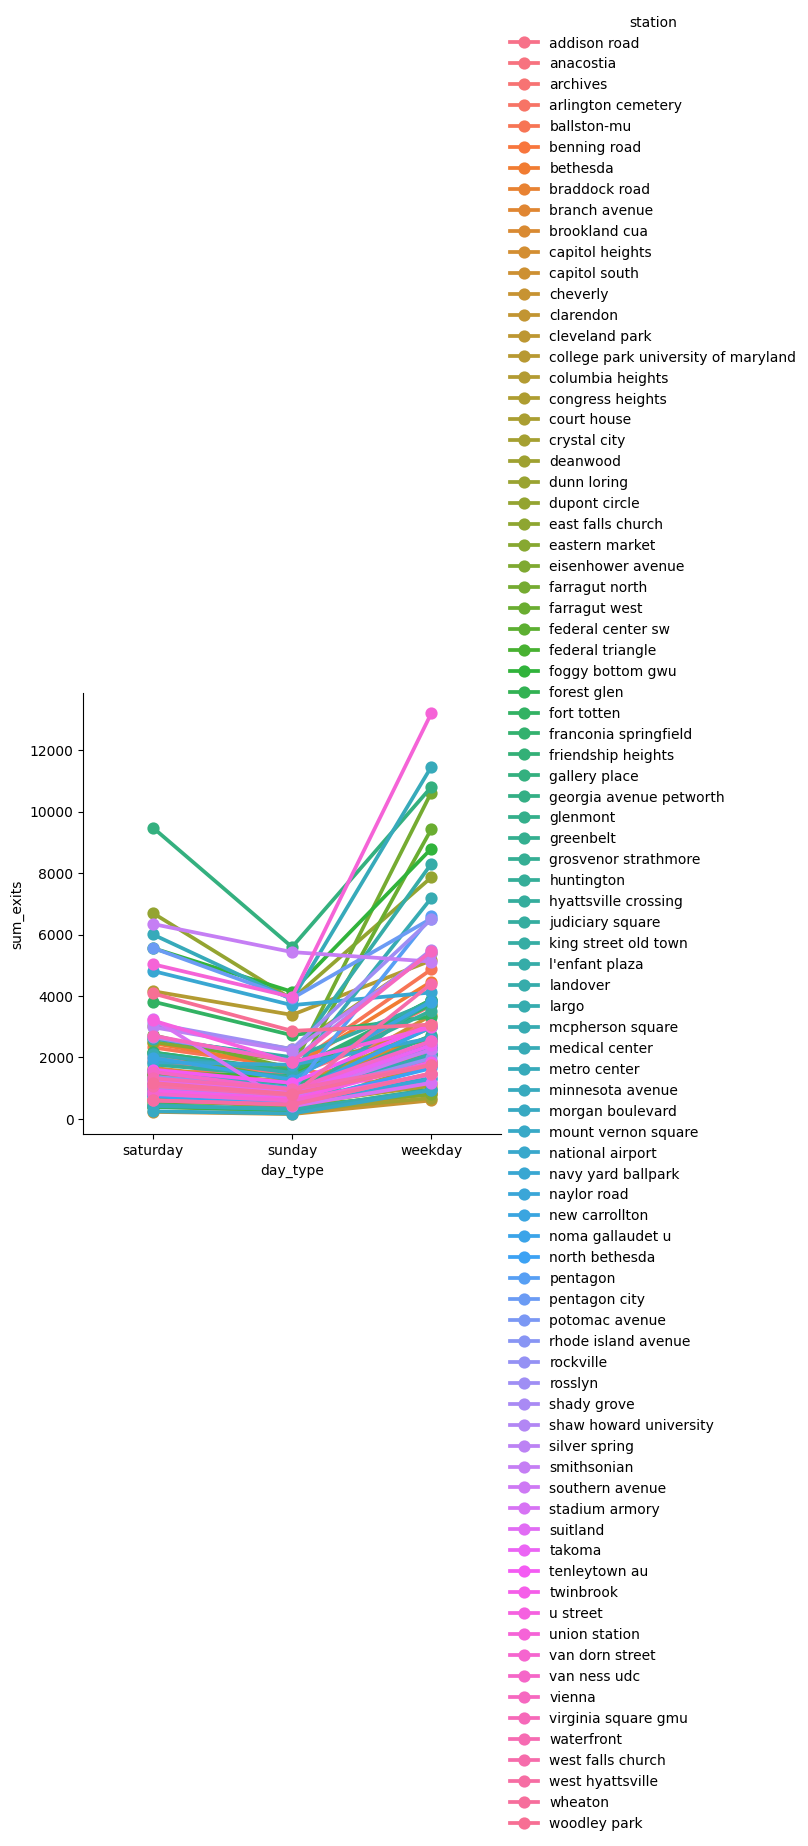

In [36]:


# Create the catplot
g = sns.catplot(
    x="day_type",
    y="sum_exits",
    data=raw,
    hue="station",
    kind="point",
    errorbar=None
)
ax = g.ax

# Function to format annotation text
def get_text_func(index):
    category = raw['day_type'].iloc[index]
    value = raw['sum_exits'].iloc[index]
    return f'Category: {category}\nValue: {value}'

# Create cursor and connect to event
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(get_text_func(sel.index)))

# Show the plot
plt.show()

In [ ]:
with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql("from mart__entry_volume_by_station_and_period where station = 'federal triangle';").show()

┌──────────────────┬──────────┬────────────┬────────────────────┬────────────────────┬─────────────────────────┬───────────────────────────────────────────┐
│     station      │ day_type │ trip_time  │  average_entries   │    sum_entries     │ trips_from_this_station │ average_number_of_stops_from_this_station │
│     varchar      │ varchar  │  varchar   │       double       │       double       │          int64          │                  double                   │
├──────────────────┼──────────┼────────────┼────────────────────┼────────────────────┼─────────────────────────┼───────────────────────────────────────────┤
│ federal triangle │ saturday │ AM Peak    │           0.734375 │              35.25 │                      48 │                         6.916666666666667 │
│ federal triangle │ saturday │ Evening    │  8.764880952380953 │             736.25 │                      84 │                        7.2976190476190474 │
│ federal triangle │ saturday │ Midday     │  8.6190476190

In [41]:
query = """with
weekdays as (
    SELECT
        ext_station,
        day_type,
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type = 'weekday'
        AND ent_time_period <> 'late_night'
    GROUP BY 1,2,3
),
weekends as (
    SELECT
        ext_station,
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type IN ('saturday', 'sunday')
        AND ent_time_period <> 'late_night'
    GROUP BY 1,2
),

weekday_weekend_ratio as (
    SELECT
        wd.ext_station as exit_station,
        wd.ent_time_period as time_of_day,
        wd.sum_riders as weekday_exits,
        we.sum_riders as weekend_exits,
        wd.sum_riders / we.sum_riders as weekday_to_weekend_ratio
    FROM weekdays as wd
    LEFT JOIN weekends as we
        ON wd.ext_station = we.ext_station
        AND wd.ent_time_period = we.ent_time_period
    ORDER BY weekday_to_weekend_ratio DESC
)

SELECT * FROM weekday_weekend_ratio;"""

with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql(query).show()

┌────────────────────┬─────────────┬────────────────────┬───────────────┬──────────────────────────┐
│    exit_station    │ time_of_day │   weekday_exits    │ weekend_exits │ weekday_to_weekend_ratio │
│      varchar       │   varchar   │       double       │    double     │          double          │
├────────────────────┼─────────────┼────────────────────┼───────────────┼──────────────────────────┤
│ federal center sw  │ AM Peak     │ 13604.863636363636 │        581.25 │       23.406217008797654 │
│ farragut west      │ AM Peak     │  46493.18181818181 │        2299.5 │        20.21882227361679 │
│ medical center     │ AM Peak     │ 11187.409090909088 │         604.5 │       18.506880216557633 │
│ pentagon           │ AM Peak     │ 20861.999999999993 │       1143.75 │       18.239999999999995 │
│ mcpherson square   │ AM Peak     │  33556.36363636364 │       2142.75 │       15.660419384605595 │
│ judiciary square   │ AM Peak     │  19546.09090909091 │       1265.25 │       15.44840222

In [42]:
query = """with
weekdays as (
    SELECT
        ent_station,
        day_type,
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type = 'weekday'
        AND ent_time_period <> 'late_night'
    GROUP BY 1,2,3
),
weekends as (
    SELECT
        ent_station,
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type IN ('saturday', 'sunday')
        AND ent_time_period <> 'late_night'
    GROUP BY 1,2
),

weekday_weekend_ratio as (
    SELECT
        wd.ent_station as entrance_station,
        wd.ent_time_period as time_of_day,
        wd.sum_riders as weekday_entrances,
        we.sum_riders as weekend_entrances,
        wd.sum_riders / we.sum_riders as weekday_to_weekend_ratio
    FROM weekdays as wd
    LEFT JOIN weekends as we
        ON wd.ent_station = we.ent_station
        AND wd.ent_time_period = we.ent_time_period
    ORDER BY weekday_to_weekend_ratio DESC
)

SELECT * FROM weekday_weekend_ratio;"""

with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql(query).show()

┌──────────────────────┬─────────────┬────────────────────┬───────────────────┬──────────────────────────┐
│   entrance_station   │ time_of_day │ weekday_entrances  │ weekend_entrances │ weekday_to_weekend_ratio │
│       varchar        │   varchar   │       double       │      double       │          double          │
├──────────────────────┼─────────────┼────────────────────┼───────────────────┼──────────────────────────┤
│ west falls church    │ AM Peak     │  20448.27272727272 │           1301.25 │       15.714330626146182 │
│ union station        │ AM Peak     │  29135.18181818181 │           3153.75 │        9.238266133390981 │
│ cleveland park       │ AM Peak     │  6987.545454545456 │            782.25 │         8.93262442255731 │
│ pentagon             │ AM Peak     │ 19437.136363636368 │            2218.5 │        8.761386686335978 │
│ largo                │ AM Peak     │  9801.409090909086 │           1161.75 │        8.436762720816946 │
│ grosvenor strathmore │ AM Peak     

In [30]:
query = """
    SELECT
        ext_station,
        any_value(day_type),
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type IN ('saturday', 'sunday')
        AND ent_time_period <> 'late_night'
        AND ext_station = 'federal triangle'
    GROUP BY 1,3
"""

with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql(query).show()

┌──────────────────┬─────────────────────┬─────────────────┬────────────┐
│   ext_station    │ any_value(day_type) │ ent_time_period │ sum_riders │
│     varchar      │       varchar       │     varchar     │   double   │
├──────────────────┼─────────────────────┼─────────────────┼────────────┤
│ federal triangle │ sunday              │ Midday          │    10305.0 │
│ federal triangle │ sunday              │ PM Peak         │     3151.5 │
│ federal triangle │ saturday            │ AM Peak         │    3011.25 │
│ federal triangle │ sunday              │ Evening         │     812.25 │
└──────────────────┴─────────────────────┴─────────────────┴────────────┘



In [38]:
query = """
    SELECT
        ext_station,
        day_type,
        ent_time_period,
        sum(riders) as sum_riders
    FROM MART__RIDERSHIP_ENRICHED
    WHERE day_type IN ('saturday', 'sunday')
        AND ent_time_period <> 'late_night'
        AND ext_station = 'federal triangle'
    GROUP BY 1,2,3
"""

with duckdb.connect(root_dir + "/metro_analytics_dbt/dev.duckdb") as con:
    raw = con.sql(query).show()

┌──────────────────┬──────────┬─────────────────┬────────────┐
│   ext_station    │ day_type │ ent_time_period │ sum_riders │
│     varchar      │ varchar  │     varchar     │   double   │
├──────────────────┼──────────┼─────────────────┼────────────┤
│ federal triangle │ sunday   │ PM Peak         │    1329.75 │
│ federal triangle │ saturday │ AM Peak         │     1218.0 │
│ federal triangle │ saturday │ PM Peak         │    1821.75 │
│ federal triangle │ sunday   │ AM Peak         │    1793.25 │
│ federal triangle │ sunday   │ Evening         │     285.75 │
│ federal triangle │ saturday │ Evening         │      526.5 │
│ federal triangle │ sunday   │ Midday          │     5007.0 │
│ federal triangle │ saturday │ Midday          │     5298.0 │
└──────────────────┴──────────┴─────────────────┴────────────┘

